# PART III - Data Modelling for Parkinson's Disease Detection using Ensemble Techniques in ML

In the third part of Parkinson's Disease Detection project, we will use the PyCaret library to build various machine learning models, and also use various ensemble techniques to predict Parkinson's disease with good evaluation metrics scores.

So let's get started.

In this section, we will perform the following steps:
- Set the target column
- Create Model: create a model, perform stratified cross validation and evaluate classification metrics
- Tune Model: tune the hyper-parameters of a classification model
- Ensemble Model: uses bagging and boosting techniques to reduce variance and bias respectively
- Blend Model: combines different machine learning algorithms and use a majority vote or the average predicted probabilities in case of classification to predict the final outcome
- Stacking: builds a meta model that generates the final prediction using the prediction of multiple base estimators
- Plot Model: analyze model performance using various plots
- Finalize Model: finalize the best model at the end of the experiment
- Predict Model: make predictions on new / unseen data
- Save / Load Model: save / load a model for future use


To begin with, we'll import the necessary libraries and load the dataset.

## **Loading the libraries**

In [ ]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
import copy
from pycaret import classification
from pycaret.classification import *

# to remove future warnings with seaborn
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# to disable INFO LOG messages
import logging, sys
logging.disable(sys.maxsize)

## **Importing the dataset**

In [ ]:
dataset = pd.read_csv('ParkinsonCleanData.csv',index_col=0)
dataset.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


## **Overview**

The classification goal is to predict the likelihood of a person having Parkinson'e disease. This is a binary classification model as the goal is to predict categorical class labels which are discrete and unoredered. 
- In this project, the categorical class is:
    - 1 (patient with Parkinson's disease)
    - 0 (patient without Parkinson's disease)

PyCaret's classification module (pycaret.classification) is a supervised machine learning module which is used for classifying the elements into a binary group based on various techniques and algorithms. 
The PyCaret classification module can be used for Binary or Multi-class classification problems. It has over 18 algorithms and 14 plots to analyze the performance of models.

## **Preparing the Dataset**

The ParkinsonCleanData contains a total number of 195 observations out of which only 147 observations have target class equal to 1.
In order to demonstrate the predict_model() function on unseen data, a sample of 10 records has been withheld from the original dataset to be used for predictions. This should not be confused with a train/test split as this particular split is performed to simulate a real life scenario. Another way to think about this is that these 10 records are not available at the time when the machine learning experiment was performed.

In [ ]:
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (185, 24)
Unseen Data For Predictions: (10, 24)


## **Setting the Target column**

The setup() function initializes the environment in pycaret, and prepares the data for modeling and deployment. setup() must be called before executing any other function in pycaret. It takes two mandatory parameters: a pandas dataframe and the name of the target column. All other parameters are optional.

When setup() is executed, PyCaret's inference algorithm will automatically infer the data types for all features based on certain properties. The data type should be inferred correctly but this is not always the case. To account for this, PyCaret displays a table containing the features and their inferred data types after setup() is executed. If all of the data types are correctly identified enter can be pressed to continue or quit can be typed to end the expriment. 

### ***Train-Test Split (70:30)***

In Machine Learning, we spilt the dataset into train and test data. We perform optimization of the hyperparameters in PyCaret using k-fold cross validation on train dataset only. Test dataset is used only to evaluate metrics and determine if the model has over-fitted the data. By default, PyCaret uses 70% of the dataset for training and 30% for testing. The proportion of split can be changed using train_size parameter within setup().

In [ ]:
data_setup=setup(data=data,
                 target='status',
                 normalize = True, 
                 transformation = True,
                 ignore_low_variance = True,
                 remove_multicollinearity = True, 
                 multicollinearity_threshold = 0.95,
                 fix_imbalance= True, 
                 profile=False)

Setup Succesfully Completed!


,Description,Value
0,session_id,2964
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(185, 24)"
4,Missing Values,False
5,Numeric Features,22
6,Categorical Features,1
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


The dataset contains only 147 entries (out of 195) where target class is 1.
Since our dataset has unequal distribution of target class it can be fixed using fix_imbalance parameter. When set to True, SMOTE (Synthetic Minority Over-sampling Technique) is applied by default to create synthetic datapoints for minority class. 

The following techniques are used:
- normalize: The dataset contains features that have variance that is larger in order of magnitude than other features, the model may not understand all features correctly and could perform poorly. For e.g., the MDVP:Jitter(Abs) feature ranges between 0.000007 and 0.000260, whereas the MDVP:Fhi(Hz) feature ranges from 102.145000 to 592.030000.
- transformation: While normalization transforms the range of data to remove the impact of magnitude in variance, transformation is a more radical technique as it changes the shape of the distribution so that transformed data can be represented by a normal or approximate normal distirbution. In general, you should transform the data if using algorithms that assume normality or a gaussian distribution. Examples of such models are Logistic Regression, Linear Discriminant Analysis (LDA) and Gaussian Naive Bayes
- ignore low variance: The dataset contains categorical features that have a single unique or small number of values across samples. This kind of features are not only non-informative and add no value but are also sometimes harmful for few algorithms. They can be removed from the dataset by using the ignore low variance feature in PyCaret.
- remove multicollinearity: In our dataset, Shimmer:APQ3 and Shimmer:DDA features have high multicollinearity. Multi-collinearity may reduce overall coefficient of the model and cause unpredictable variance. This will lead to overfitting where the model may do great on a known training set but will fail with an unknown testing set.Thus, we need to remove multicollinearity between features vefore creating a model. 
- bin numeric feature: When looking at the correlations between the numeric features and the target variable, we see that DFA, NHR and MDVP:Fhi(Hz) are weak. We will use the bin_numeric_features parameter to remove the noise from these variables. Binning or discretization is the process of transforming numerical variables into categorical features. An example would be the MDVP:Flo(Hz) variable which is a continuous distribution of numeric values that can be discretized into intervals (65-84, 85-104 etc.)

## **Comparing All Models**

Comparing all models to evaluate performance is the first stage of modeling, once the setup is completed (unless you exactly know what kind of model you need, which is often not the case). This function trains all the models in the model library and scores them using stratified cross validation for metric evaluation. The output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1, Kappa, and MCC accross the folds (10 by default) along with training times.

In [ ]:
# selecting top 3 models
best_models = compare_models(n_select=3, sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Extra Trees Classifier,0.9218,0.9563,0.9489,0.9482,0.9471,0.7929,0.7997,0.1462
1,Gradient Boosting Classifier,0.9071,0.9419,0.9500,0.9303,0.9358,0.7598,0.7797,0.0821
2,Random Forest Classifier,0.9071,0.9280,0.9300,0.9452,0.9324,0.7746,0.7861,0.1116
3,CatBoost Classifier,0.9071,0.9663,0.9300,0.9452,0.9319,0.7791,0.7937,1.6463
4,Light Gradient Boosting Machine,0.8994,0.9461,0.9389,0.9282,0.9299,0.7411,0.7574,0.0252
5,Extreme Gradient Boosting,0.8994,0.9222,0.9289,0.9364,0.9294,0.7468,0.7584,0.0236
6,Decision Tree Classifier,0.8840,0.8661,0.8989,0.9464,0.9183,0.7109,0.7235,0.0028
7,Quadratic Discriminant Analysis,0.8519,0.8007,0.9600,0.8653,0.9079,0.5208,0.5367,0.0021
8,Ada Boost Classifier,0.8609,0.8594,0.8989,0.9166,0.9035,0.6418,0.6618,0.0660
9,Logistic Regression,0.8218,0.8622,0.8578,0.9060,0.8791,0.5328,0.5425,0.0081


The score grid printed above highlights the highest performing metric for comparison purposes only. The grid by default is sorted using 'Accuracy' (highest to lowest) which can be changed by passing the sort parameter. For example compare_models(sort = 'Recall') will sort the grid by Recall instead of Accuracy. If you want to change the fold parameter from the default value of 10 to a different value then you can use the fold parameter. For example compare_models(fold = 5) will compare all models on 5 fold cross validation. Reducing the number of folds will improve the training time. By default, compare_models return the best performing model based on default sort order but can be used to return a list of top N models by using n_select parameter.

For this dataset, it is important for the model to predict patients with Parkinson's disease. A challenge when developing prediction models with this type of data is the balance between precision and recall:
- Precision represents the proportion of the models’ predictions of Parkinson's disease where Parkinson is actually present.
- Recall represents the proportion of all cases of Parkinson's disease that the model accurately predicted.

Because not “capturing” even one case of disease could result in death, the models should place emphasis on the recall score. It is far preferable to not “miss” anyone with disease even if that means “flagging” some patients as having disease that actually do not have the disease.

Since the dataset has 147 positive cases out of total 195 patients, the model is imbalanced. The model may predict that everyone does not have disease with a precison score of 100% but a recall score of 1%. A predictive model such as this would be of no value. 

The goal for a predictive model in this scenario is to identify as high a percentage as possible of the Parkinson's disease cases with as few as possible “false positives” (prediction of disease but in fact no Parkinson).

We will look at recall first and foremost, and then the F1 score, which is a measurement reflecting an equally balanced weighting of both precision and recall:
            F1 = precision * recall/ precision + recall


In [ ]:
print(best_models)

[ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=588, verbose=0,
                     warm_start=False), GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                         

The top 3 models are:
    - Extra Trees Classifier Classifier
    - Gradient Boosting Classifier
    - Random Forest Classifier    

## **Creating Models**

We will now use the top 5 models to train and evaluate models using cross validation.

### ***Creating an Extra Trees Classifier Model***

Before we create a model, we must know the ID of each model. We can find the ID using the models() function.

In [ ]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors.KNeighborsClassifier,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model.SGDClassifier,True
rbfsvm,SVM - Radial Kernel,sklearn.svm.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process.GPC,False
mlp,MLP Classifier,sklearn.neural_network.MLPClassifier,False
ridge,Ridge Classifier,sklearn.linear_model.RidgeClassifier,True


In [ ]:
et = create_model('et',fold = 8,round = 2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.88,0.88,1.00,0.87,0.93,0.60,0.66
1,0.94,0.94,1.00,0.92,0.96,0.82,0.83
2,0.94,0.96,0.92,1.00,0.96,0.85,0.86
3,0.94,0.98,0.92,1.00,0.96,0.85,0.86
4,0.88,0.96,1.00,0.86,0.92,0.60,0.65
5,0.88,0.94,0.92,0.92,0.92,0.67,0.67
6,0.94,1.00,0.92,1.00,0.96,0.85,0.86
7,0.94,1.00,0.92,1.00,0.96,0.82,0.83
Mean,0.91,0.96,0.95,0.95,0.94,0.76,0.78
SD,0.03,0.04,0.04,0.06,0.02,0.10,0.09


The Extra Trees classifier model has high Standard Deviation, which means the model is overfit. Also, all the model metrics are greater than 75%, which means the model is not underfit.

### ***Creating a Gradient Boosting Classifier Model***

In [ ]:
gbc = create_model('gbc',fold = 8,round = 2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.88,0.90,1.00,0.87,0.93,0.60,0.66
1,0.88,0.96,1.00,0.86,0.92,0.60,0.65
2,0.88,0.96,1.00,0.86,0.92,0.60,0.65
3,0.88,1.00,0.83,1.00,0.91,0.71,0.75
4,0.75,0.88,0.83,0.83,0.83,0.33,0.33
5,0.88,0.90,0.92,0.92,0.92,0.67,0.67
6,0.94,0.96,0.92,1.00,0.96,0.85,0.86
7,0.94,0.95,0.92,1.00,0.96,0.82,0.83
Mean,0.88,0.94,0.93,0.92,0.92,0.65,0.68
SD,0.05,0.04,0.06,0.07,0.04,0.15,0.15


In GBC model, the standard deviation is quite high. But the metrics clock more than 65% which is fairly good.

### ***Creating a Random Forest Classifier Model***

In [ ]:
rf = create_model('rf',fold = 8,round = 2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.88,0.97,1.00,0.87,0.93,0.60,0.66
1,0.81,0.90,0.83,0.91,0.87,0.54,0.54
2,0.94,0.90,1.00,0.92,0.96,0.82,0.83
3,0.94,0.96,0.92,1.00,0.96,0.85,0.86
4,0.81,0.82,0.92,0.85,0.88,0.45,0.46
5,0.81,0.85,0.83,0.91,0.87,0.54,0.54
6,1.00,1.00,1.00,1.00,1.00,1.00,1.00
7,0.88,0.96,0.85,1.00,0.92,0.67,0.71
Mean,0.88,0.92,0.92,0.93,0.92,0.68,0.70
SD,0.07,0.06,0.07,0.06,0.04,0.18,0.17


The Random Forest Classifier model has a better performance than GBC model. 

### ***Creating a Catboost Classifier Model***

In [ ]:
catboost = create_model('catboost',fold = 8,round = 2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.88,1.00,1.00,0.87,0.93,0.60,0.66
1,0.88,0.94,0.92,0.92,0.92,0.67,0.67
2,0.88,0.94,0.92,0.92,0.92,0.67,0.67
3,0.88,0.98,0.92,0.92,0.92,0.67,0.67
4,0.81,0.88,0.92,0.85,0.88,0.45,0.46
5,0.88,0.92,0.92,0.92,0.92,0.67,0.67
6,0.94,0.96,0.92,1.00,0.96,0.85,0.86
7,0.94,0.97,0.92,1.00,0.96,0.82,0.83
Mean,0.88,0.95,0.93,0.92,0.92,0.67,0.68
SD,0.04,0.04,0.03,0.05,0.02,0.11,0.11


The Catboost and RF are qually good. The AUC in Catboost is outstanding.

### ***Creating a Light Gradient Boosting Machine Model***

In [ ]:
lightgbm = create_model('lightgbm',fold = 8,round = 2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.88,0.87,1.00,0.87,0.93,0.60,0.66
1,0.94,1.00,1.00,0.92,0.96,0.82,0.83
2,0.88,0.94,1.00,0.86,0.92,0.60,0.65
3,0.88,0.98,0.83,1.00,0.91,0.71,0.75
4,0.94,0.94,1.00,0.92,0.96,0.82,0.83
5,0.88,0.96,0.92,0.92,0.92,0.67,0.67
6,0.88,0.96,0.92,0.92,0.92,0.67,0.67
7,0.88,0.95,0.85,1.00,0.92,0.67,0.71
Mean,0.89,0.95,0.94,0.93,0.93,0.70,0.72
SD,0.03,0.04,0.07,0.05,0.02,0.08,0.07


The light GBM model has fairly good performance like all the models.

### ***Creating a K Neighbors Classifier Model***

In [ ]:
knn = create_model('knn',fold = 8,round = 2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.76,0.94,0.77,0.91,0.83,0.44,0.46
1,0.94,0.99,0.92,1.00,0.96,0.85,0.86
2,0.88,0.96,0.83,1.00,0.91,0.71,0.75
3,0.81,0.98,0.75,1.00,0.86,0.60,0.65
4,0.94,0.99,0.92,1.00,0.96,0.85,0.86
5,0.81,0.94,0.75,1.00,0.86,0.60,0.65
6,0.88,0.93,0.83,1.00,0.91,0.71,0.75
7,0.69,0.96,0.62,1.00,0.76,0.38,0.48
Mean,0.84,0.96,0.80,0.99,0.88,0.64,0.68
SD,0.08,0.02,0.09,0.03,0.06,0.16,0.14


The KNN Classifier model has a low recall compared to other models. But the precision is very high.

### ***Creating a Quadratic Discriminant Analysis Model***

In [ ]:
qda = create_model('qda',fold = 8,round = 2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.88,0.67,1.00,0.87,0.93,0.60,0.66
1,0.94,0.83,1.00,0.92,0.96,0.82,0.83
2,0.81,0.76,0.92,0.85,0.88,0.45,0.46
3,0.94,0.98,1.00,0.92,0.96,0.82,0.83
4,0.69,0.71,0.92,0.73,0.81,-0.11,-0.15
5,0.94,0.94,1.00,0.92,0.96,0.82,0.83
6,0.81,0.92,1.00,0.80,0.89,0.33,0.45
7,0.81,0.87,0.85,0.92,0.88,0.45,0.46
Mean,0.85,0.84,0.96,0.87,0.91,0.52,0.55
SD,0.08,0.10,0.06,0.07,0.05,0.30,0.31


The QDA Classifier model also high standard deviation which means the model is overfit. And, all the metrics are more than 50% which means that the model is overfit. The Recall metric is the highest amongst all the models.

OBSERVATION:
    - Accuracy : Extra Trees Classifier model has the highest accuracy mean score of 0.91, and RF and Catboost have 0.89
    - AUC : Extra Trees Classifier and Catboost models have AUC mean score of 0.97, and knn has 0.95
    - Recall : Quadratic Discriminant Analysis model has recall mean score of 0.97 and Extra Tress Classifier model has a 
               recall mean score of 0.96
    - Precision : knn model has the highest precision mean score of 0.97, and RF, Catboost and LightGBM has 0.94
    - F1 - Extra Trees Classifier has the precsion mean score of 0.94, and RF and Catboost have 0.93
    
Extra Trees Classifier, RF and Catboost models fairly higher performance amongst all the top 5 models.

## **Tuning Models**

When a model is created using the create_model() function, it uses the default hyperparameters to train the model. In order to tune hyperparameters, the tune_model() function is used. This function automatically tunes the hyperparameters of a model using Random Grid Search on a pre-defined search space. The output prints a score grid that shows Accuracy, AUC, Recall, Precision, F1, Kappa, and MCC by fold for the best model.

Out of all the metrics, Recall is more important because our model should minimize the wrong predictions of a patient not having the Parkinson's disease. So, when we tune the models, we will optimize the Recall hyperparameter.

### ***Tuning the Extra Trees Classifier Model***

In [ ]:
tuned_et = tune_model(et, optimize = 'Recall', fold = 8,round = 2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.71,0.77,0.77,0.83,0.80,0.25,0.25
1,0.75,0.90,0.75,0.90,0.82,0.43,0.45
2,0.75,0.85,0.67,1.00,0.80,0.50,0.58
3,0.81,0.98,0.75,1.00,0.86,0.60,0.65
4,0.81,0.85,0.83,0.91,0.87,0.54,0.54
5,0.56,0.83,0.50,0.86,0.63,0.18,0.22
6,0.94,1.00,0.92,1.00,0.96,0.85,0.86
7,0.81,0.90,0.77,1.00,0.87,0.56,0.62
Mean,0.77,0.89,0.74,0.94,0.83,0.49,0.52
SD,0.10,0.07,0.11,0.07,0.09,0.20,0.20


### ***Tuning the Random Forest Classifier Model***

In [ ]:
tuned_rf = tune_model(rf, optimize = 'Recall', fold = 8,round = 2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.88,0.90,1.00,0.87,0.93,0.60,0.66
1,0.94,0.92,1.00,0.92,0.96,0.82,0.83
2,0.75,0.90,0.83,0.83,0.83,0.33,0.33
3,0.94,1.00,0.92,1.00,0.96,0.85,0.86
4,0.88,0.88,1.00,0.86,0.92,0.60,0.65
5,0.88,0.77,0.92,0.92,0.92,0.67,0.67
6,0.94,1.00,0.92,1.00,0.96,0.85,0.86
7,0.94,0.97,0.92,1.00,0.96,0.82,0.83
Mean,0.89,0.92,0.94,0.92,0.93,0.69,0.71
SD,0.06,0.07,0.05,0.06,0.04,0.17,0.17


### ***Tuning the Catboost Classifier Model***

In [ ]:
tuned_catboost = tune_model(catboost, optimize = 'Recall', fold = 8,round = 2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.76,0.81,0.85,0.85,0.85,0.35,0.35
1,0.81,0.88,0.83,0.91,0.87,0.54,0.54
2,0.75,0.88,0.75,0.90,0.82,0.43,0.45
3,0.88,0.96,0.83,1.00,0.91,0.71,0.75
4,0.75,0.79,0.83,0.83,0.83,0.33,0.33
5,0.81,0.83,0.83,0.91,0.87,0.54,0.54
6,0.88,1.00,0.83,1.00,0.91,0.71,0.75
7,0.75,0.92,0.77,0.91,0.83,0.35,0.37
Mean,0.80,0.88,0.82,0.91,0.86,0.50,0.51
SD,0.05,0.07,0.03,0.06,0.03,0.15,0.16


### ***Tuning the Gradient Boosting Classifier Model***

In [ ]:
tuned_gbc = tune_model(gbc, optimize = 'Recall', fold = 8,round = 2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.00,1.00,1.00,1.00,1.00,1.00,1.00
1,0.94,0.98,1.00,0.92,0.96,0.82,0.83
2,0.88,0.98,0.83,1.00,0.91,0.71,0.75
3,0.94,0.98,0.92,1.00,0.96,0.85,0.86
4,0.94,0.94,1.00,0.92,0.96,0.82,0.83
5,0.88,0.85,0.92,0.92,0.92,0.67,0.67
6,0.94,0.96,0.92,1.00,0.96,0.85,0.86
7,0.88,0.97,0.85,1.00,0.92,0.67,0.71
Mean,0.92,0.96,0.93,0.97,0.95,0.80,0.81
SD,0.04,0.04,0.06,0.04,0.03,0.10,0.10


### ***Tuning the Light GBM Classifier Model***

In [ ]:
tuned_lightgbm = tune_model(lightgbm, optimize = 'Recall', fold = 8,round = 2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.82,0.77,0.92,0.86,0.89,0.46,0.47
1,0.88,0.90,0.92,0.92,0.92,0.67,0.67
2,0.94,0.92,1.00,0.92,0.96,0.82,0.83
3,0.81,0.96,0.75,1.00,0.86,0.60,0.65
4,0.75,0.73,0.83,0.83,0.83,0.33,0.33
5,0.88,0.94,0.92,0.92,0.92,0.67,0.67
6,0.88,0.92,0.83,1.00,0.91,0.71,0.75
7,0.88,0.95,0.85,1.00,0.92,0.67,0.71
Mean,0.85,0.88,0.88,0.93,0.90,0.62,0.64
SD,0.05,0.08,0.07,0.06,0.04,0.14,0.15


### ***Tuning the K Neighbors Classifier Model***

In [ ]:
tuned_knn = tune_model(knn, optimize = 'Recall', fold = 8,round = 2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.65,0.61,0.69,0.82,0.75,0.16,0.17
1,0.69,0.83,0.67,0.89,0.76,0.33,0.36
2,0.75,0.84,0.67,1.00,0.80,0.50,0.58
3,0.75,0.94,0.67,1.00,0.80,0.50,0.58
4,0.81,0.88,0.75,1.00,0.86,0.60,0.65
5,0.62,0.74,0.58,0.88,0.70,0.25,0.29
6,0.81,0.93,0.75,1.00,0.86,0.60,0.65
7,0.75,0.95,0.69,1.00,0.82,0.46,0.54
Mean,0.73,0.84,0.68,0.95,0.79,0.43,0.48
SD,0.07,0.11,0.05,0.07,0.05,0.15,0.17


### ***Tuning the Quadratic Discriminant Analysis Model***

In [ ]:
tuned_qda = tune_model(qda, optimize = 'Recall', fold = 8,round = 2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.71,0.75,0.77,0.83,0.80,0.25,0.25
1,0.88,0.92,0.92,0.92,0.92,0.67,0.67
2,0.81,0.81,0.75,1.00,0.86,0.60,0.65
3,0.81,0.90,0.83,0.91,0.87,0.54,0.54
4,0.81,0.81,0.92,0.85,0.88,0.45,0.46
5,0.81,0.90,0.83,0.91,0.87,0.54,0.54
6,0.94,1.00,0.92,1.00,0.96,0.85,0.86
7,0.81,0.95,0.77,1.00,0.87,0.56,0.62
Mean,0.82,0.88,0.84,0.93,0.88,0.56,0.58
SD,0.06,0.08,0.07,0.06,0.04,0.16,0.16


Surprisingly, out of all the three models, the Gradient Boosting Classifier Model has the best performance by tuning the Recall hyperparameter. So, we will use this model for prediction.

## **Plotting Models**

Before model finalization, the plot_model() function can be used to analyze the performance across different aspects such as AUC, confusion_matrix, decision boundary etc. This function takes a trained model object and returns a plot based on the test / hold-out set.

### ***Plotting Extra Trees Classifier Model***

#### **AUC Plot**

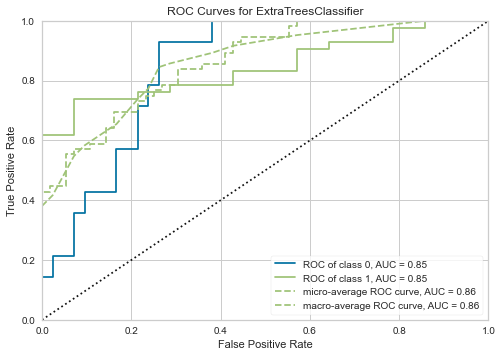

In [ ]:
plot_model(tuned_et, plot = 'auc')

- Receiver Operating Characteristic (ROC) measures the performance of models by evaluating the trade-offs between sensitivity (True Positive Rate) and 1-Specificity (False Positive Rate)
- Sensitivity or Recall is the measure of actual observations which are predicted correctly
- Specificity is the measure of how many observations of false category predicted correctly
- Area Under Curve (AUC) is the measure of accuracy judged by the area under curve for ROC

Observation:
- The ROC curves for LGBM Classifier model is 0.99 which is very high. Therefore, the model can be considered for prediction.


#### **Precision-Recall Curve**

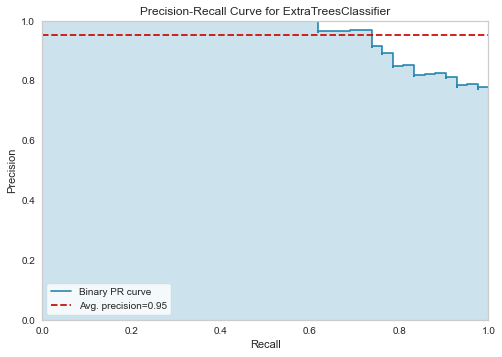

In [ ]:
plot_model(tuned_et, plot = 'pr')

- Precision is the measure of correctness achieved in prediction. It is measured as TP/TP+FP
- Recall is the measure of actual observations which are predicted correctly. It is measured as TP/TP+FN

Observation:
- The average precision for LGBM Classifier model is 0.95 which is a good vlaue.

#### **Feature Importance Plot**

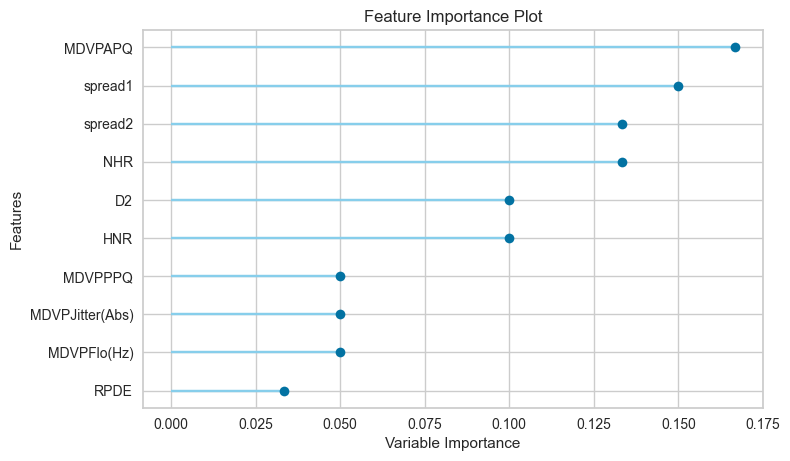

In [ ]:
plot_model(tuned_et, plot='feature')

#### **Confusion Matrix**

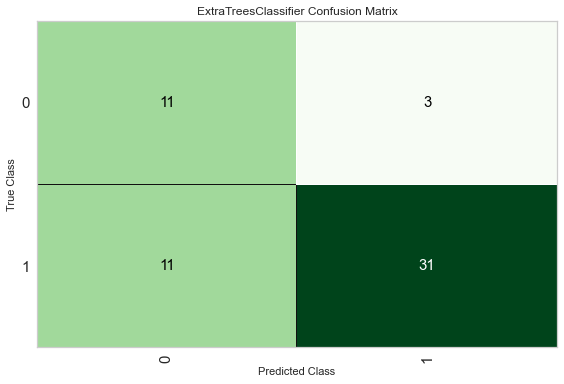

In [ ]:
plot_model(tuned_et, plot = 'confusion_matrix')

Observation:
- True Positives: 
    - Number of observations in which the actual value is positive and the model predicted a positive value
    - The number of True Positives are 11
- True Negatives: 
    - Number of observations in which the actual value is negative and the model predicted a negative value
    - The number of True Negatives are 31
- False Positives (Type I error): 
    - Number of observations in which the actual value is negative and the model predicted a positive value
    - The number of False Positives are 3
- False Negatives (Type II error): 
    - Number of observations in which the actual value is positive and the model predicted a negative value
    - The number of False Negatives are 11
    
The model wrongly predicted that 3 patients do not have Parkinson's disease.

<span style="font-family: Arial; font-weight:bold;font-size:1.2em;color:#4E9258"> Plotting RF Classifier Model

<span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#920445"> AUC Plot

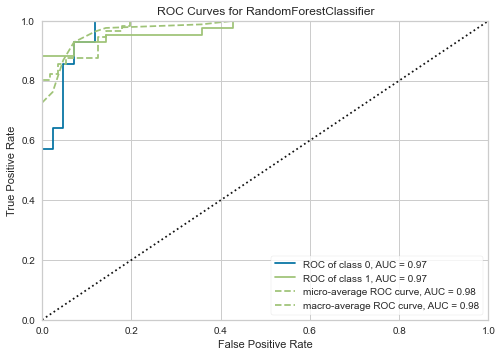

In [ ]:
plot_model(tuned_rf, plot = 'auc')

<span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#920445"> Precision-Recall Curve

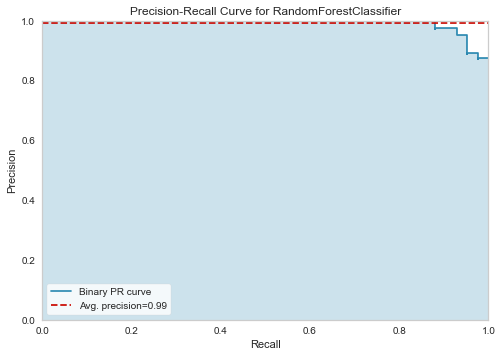

In [ ]:
plot_model(tuned_rf, plot = 'pr')

<span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#920445"> Feature Importance Plot

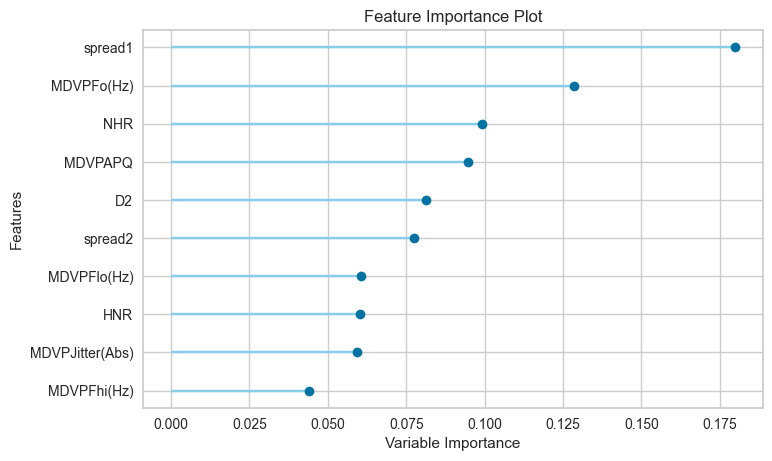

In [ ]:
plot_model(tuned_rf, plot='feature')

<span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#920445"> Confusion Matrix

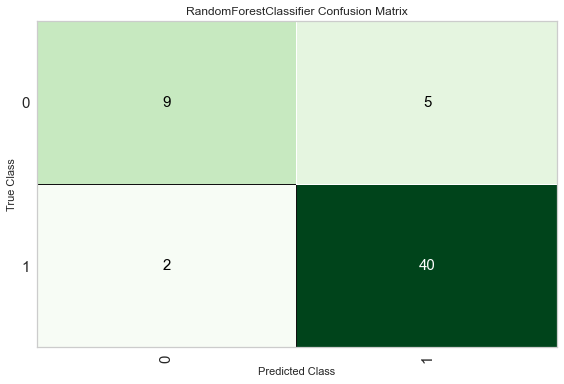

In [ ]:
plot_model(tuned_rf, plot = 'confusion_matrix')

The RF Classifier model has an excellent performance with AUC of 0.98 and average precision of 0.99. Also, the number of FP is only 5 and FN is 2.

### ***Plotting Catboost Classifier Model***

#### **AUC Plot**

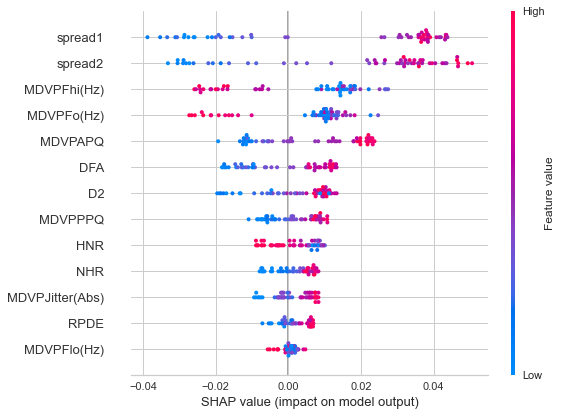

In [ ]:
interpret_model(tuned_catboost, plot = 'summary');

NOTE: Plotting Models for CatBoost Classifier Model is under development by Pycaret.

### ***Plotting Gradient Boosting Classifier Model***

#### **AUC Plot**

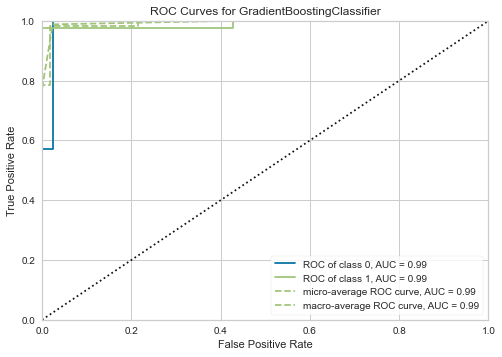

In [ ]:
plot_model(tuned_gbc, plot = 'auc')

#### **Precision-Recall Curve**

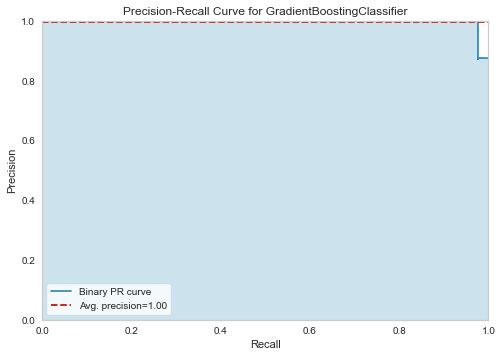

In [ ]:
plot_model(tuned_gbc, plot = 'pr')

#### **Feature Importance Plot**

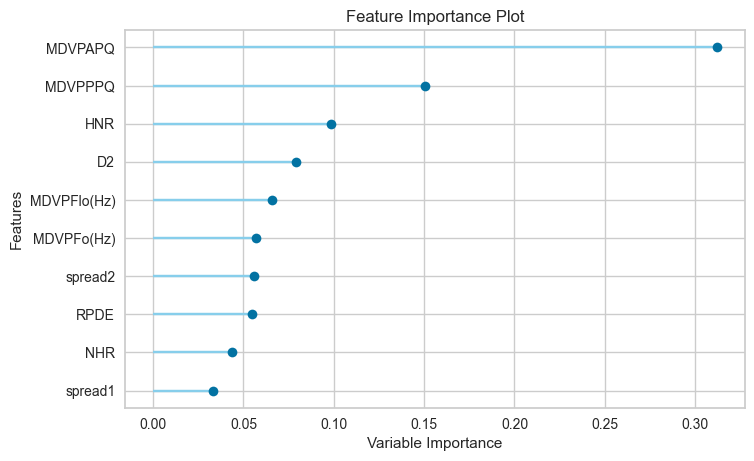

In [ ]:
plot_model(tuned_gbc, plot='feature')

#### **Confusion Matrix**

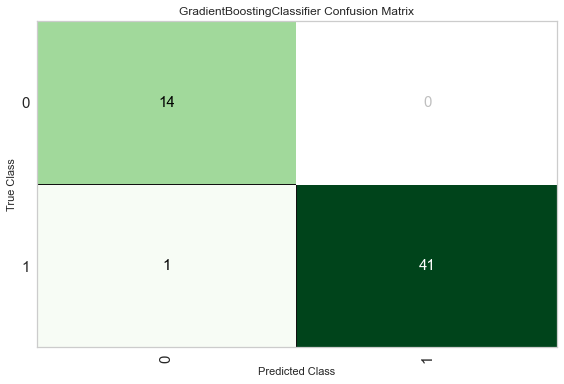

In [ ]:
plot_model(tuned_gbc, plot = 'confusion_matrix')

The GBC Classifier model has the best performance with AUC of 0.99 and average precision of 1. Also, the number of FP is 0 and FN is 1.

### ***Plotting LightGBM Classifier Model***

#### **AUC Plot**

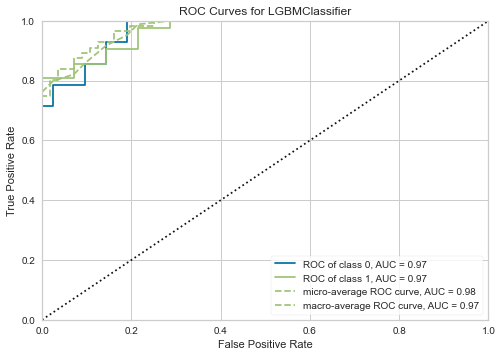

In [ ]:
plot_model(tuned_lightgbm, plot = 'auc')

#### **Precision-Recall Curve**

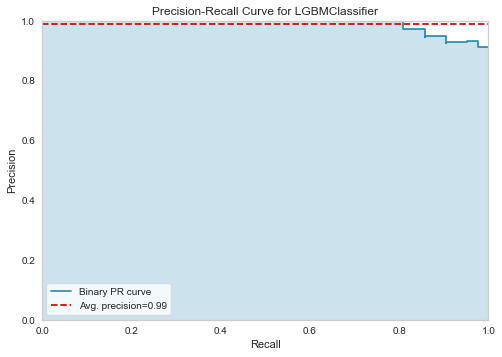

In [ ]:
plot_model(tuned_lightgbm, plot = 'pr')

#### **Feature Importance Plot**

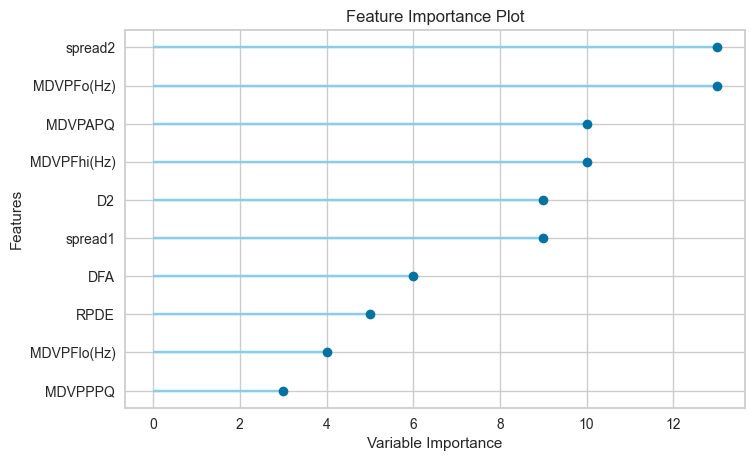

In [ ]:
plot_model(tuned_lightgbm, plot='feature')

#### **Confusion Matrix**

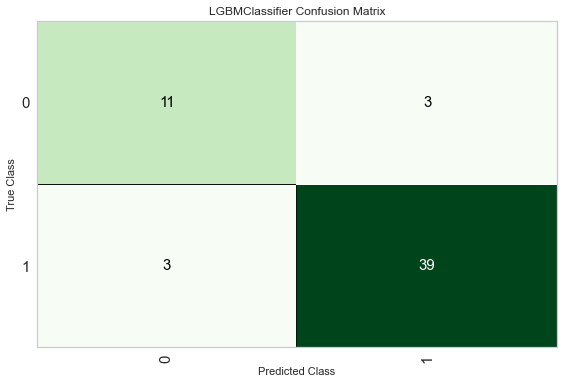

In [ ]:
plot_model(tuned_lightgbm, plot = 'confusion_matrix')

Both the LGBM Classifier is also good with AUC of 0.97 and average precision of 0.99. The number of FP and FN are 3.

## **Predicting on Test / Hold-out Sample**

Before finalizing the model, it is advisable to perform one final check by predicting the test/hold-out set and reviewing the evaluation metrics. Now, using our final trained model stored in the tuned_xgb variable, we will predict against the test (hold-out) sample and evaluate the metrics to see if they are materially different than the CV results from trained model.

In [ ]:
predict_model(tuned_gbc);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9821,0.9898,0.9762,1.0,0.988,0.9535,0.9545


In [ ]:
predict_model(tuned_rf);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.875,0.9745,0.9524,0.8889,0.9195,0.641,0.6487


In [ ]:
predict_model(tuned_et);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.75,0.8452,0.7381,0.9118,0.8158,0.44,0.4644


The accuracy on test/hold-out set is 0.98 compared to 0.99 achieved on the tuned_lgbm CV results. There is not a significance difference. Thus, we will finalize the LGBM Classifier model. 

In [ ]:
predict_model(tuned_catboost);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7857,0.8963,0.8333,0.875,0.8537,0.4545,0.4564


In [ ]:
predict_model(tuned_lightgbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8929,0.9677,0.9286,0.9286,0.9286,0.7143,0.7143


OBSERVATION:
    The Gradient Boosting Classifier model is the best model of all the models. The precision is 100%, F1 is 98.8% and Recall is 97.6%. The overall Accuracy is 98.2%

## **Ensembling Models**

Ensembling a trained model is as simple as writing ensemble_model. It takes only one mandatory parameter i.e. the trained model object. This functions returns a table with k-fold cross validated scores of common evaluation metrics along with trained model object. The evaluation metrics used are:

Classification: Accuracy, AUC, Recall, Precision, F1, Kappa, MCC
Regression: MAE, MSE, RMSE, R2, RMSLE, MAPE
The number of folds can be defined using fold parameter within ensemble_model function. By default, the fold is set to 10. All the metrics are rounded to 4 decimals by default by can be changed using round parameter. There are two methods available for ensembling that can be set using method parameter within ensemble_model function. Both the methods require re-sampling of the data and fitting multiple estimators, hence the number of estimators can be controlled using n_estimators parameter. By default, n_estimators is set to 10.

<span style="font-family: Arial; font-weight:bold;font-size:1.2em;color:#4E9258"> Applying the Bagging and Boosting Ensemble Techniques

In [ ]:
# Importing module and initializing setup 
from pycaret.classification import * 

clf1 = setup(data = data, target = 'status') 
# train a Light GBM model
rf = create_model('rf')
# train a bagging classifier on Light GBM
bagged_rf = ensemble_model(rf, method = 'Bagging')
# train an adaboost classifier on Light GBM with 100 estimators
boosted_rf = ensemble_model(rf, method = 'Boosting', n_estimators = 100)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.7692,0.9000,0.9000,0.8182,0.8571,0.2642,0.2725
2,0.6154,0.8167,0.6000,0.8571,0.7059,0.1975,0.2254
3,0.9231,0.9333,1.0000,0.9091,0.9524,0.7547,0.7785
4,0.9231,0.9667,0.9000,1.0000,0.9474,0.8060,0.8216
5,0.7692,0.9333,0.8000,0.8889,0.8421,0.4179,0.4260
6,0.9231,0.9833,0.9000,1.0000,0.9474,0.8060,0.8216
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [ ]:
# Importing module and initializing setup 
from pycaret.classification import * 

clf1 = setup(data = data, target = 'status') 
# train a Light GBM model
lgbm = create_model('lightgbm')
# train a bagging classifier on Light GBM
bagged_lgbm = ensemble_model(lgbm, method = 'Bagging')
# train an adaboost classifier on Light GBM with 100 estimators
boosted_lgbm = ensemble_model(lgbm, method = 'Boosting', n_estimators = 100)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8462,1.0000,1.0000,0.8182,0.9000,0.5806,0.6396
1,0.9231,1.0000,1.0000,0.9091,0.9524,0.7547,0.7785
2,0.8462,0.8333,0.9000,0.9000,0.9000,0.5667,0.5667
3,0.6923,0.9000,0.7000,0.8750,0.7778,0.2973,0.3175
4,0.8462,0.9333,0.8000,1.0000,0.8889,0.6486,0.6928
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
9,0.9167,0.9630,1.0000,0.9000,0.9474,0.7500,0.7746


The LightGBM model has the best performance when ensemble techniques such as bagging and boosting are applied.

## **Blending Models**

Blending models is a method of ensembling which uses consensus among estimators to generate final predictions. The idea behind blending is to combine different machine learning algorithms and use a majority vote or the average predicted probabilities in case of classification to predict the final outcome. Blending models in PyCaret is as simple as writing blend_models. This function can be used to blend specific trained models that can be passed using estimator_list parameter within blend_models or if no list is passed, it will use all the models in model library. In case of Classification, method parameter can be used to define ‘soft‘ or ‘hard‘ where soft uses predicted probabilities for voting and hard uses predicted labels. This functions returns a table with k-fold cross validated scores of common evaluation metrics along with trained model object. The evaluation metrics used are:

- Classification: Accuracy, AUC, Recall, Precision, F1, Kappa, MCC
- Regression: MAE, MSE, RMSE, R2, RMSLE, MAPE

The number of folds can be defined using fold parameter within blend_models function. By default, the fold is set to 10. All the metrics are rounded to 4 decimals by default by can be changed using round parameter within blend_models.

In [ ]:
# Importing module and initializing setup
from pycaret.classification import *
clf1 = setup(data = data, target = 'status')
# train a votingclassifier on all models in library
blender = blend_models()
# train a voting classifier on specific models
et = create_model('et')
gbc = create_model('gbc')
lightgbm = create_model('lightgbm')
rf = create_model('rf')
catboost = create_model('catboost')
blender_specific = blend_models(estimator_list = [et,gbc,lightgbm,rf,catboost], method = 'soft')
# train a voting classifier dynamically
blender_specific = blend_models(estimator_list = compare_models(n_select = 5), method = 'hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.8462,0.0000,0.9000,0.9000,0.9000,0.5667,0.5667
2,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,0.9231,0.0000,1.0000,0.9091,0.9524,0.7547,0.7785
4,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,0.9231,0.0000,1.0000,0.9091,0.9524,0.7547,0.7785
6,0.9231,0.0000,0.9000,1.0000,0.9474,0.8060,0.8216
7,0.9231,0.0000,1.0000,0.9091,0.9524,0.7547,0.7785
8,0.8462,0.0000,0.8889,0.8889,0.8889,0.6389,0.6389
9,0.9167,0.0000,1.0000,0.9000,0.9474,0.7500,0.7746


## **Stacking Models (Training a Meta Classifier)**

Stacking models is method of ensembling that uses meta learning. The idea behind stacking is to build a meta model that generates the final prediction using the prediction of multiple base estimators. Stacking models in PyCaret is as simple as writing stack_models. This function takes a list of trained models using estimator_list parameter. All these models form the base layer of stacking and their predictions are used as an input for a meta model that can be passed using meta_model parameter. If no meta model is passed, a linear model is used by default. In case of Classification, method parameter can be used to define ‘soft‘ or ‘hard‘ where soft uses predicted probabilities for voting and hard uses predicted labels. This function returns a table with k-fold cross validated scores of common evaluation metrics along with trained model object. The evaluation metrics used are:

- Classification: Accuracy, AUC, Recall, Precision, F1, Kappa, MCC
- Regression: MAE, MSE, RMSE, R2, RMSLE, MAPE

The number of folds can be defined using fold parameter within stack_models function. By default, the fold is set to 10. All the metrics are rounded to 4 decimals by default by can be changed using round parameter within stack_models. restack parameter controls the ability to expose the raw data to meta model. By default, it is set to True. When changed to False, meta-model will only use predictions of base models to generate final predictions.

In [ ]:
from pycaret.classification import *
clf1 = setup(data = data, target = 'status')
# create individual models for stacking
et = create_model('et')
gbc = create_model('gbc')
lightgbm = create_model('lightgbm')
qda = create_model('qda')
knn = create_model('knn')
xgboost = create_model('xgboost')
# stacking models
stacker = stack_models(estimator_list = [et,gbc,lightgbm,qda,knn], meta_model = xgboost)
# stack models dynamically
top5 = compare_models(n_select = 5)
stacker = stack_models(estimator_list = top5[1:], meta_model = top5[0])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9231,1.0000,1.0000,0.9091,0.9524,0.7547,0.7785
1,0.9231,1.0000,1.0000,0.9091,0.9524,0.7547,0.7785
2,0.9231,0.9000,1.0000,0.9091,0.9524,0.7547,0.7785
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.9231,1.0000,1.0000,0.9091,0.9524,0.7547,0.7785
5,0.7692,0.7667,0.9000,0.8182,0.8571,0.2642,0.2725
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
9,0.7500,0.8889,0.7778,0.8750,0.8235,0.4000,0.4082


## **Finalizing Model for Deployment**

This is the last step in the experiment. The finalize_model() function fits the model onto the complete dataset including the test/hold-out sample (30% in this case). The purpose of this function is to train the model on the complete dataset before it is deployed in production.

In [ ]:
final_gbc = finalize_model(tuned_gbc)
print(final_gbc)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.42, loss='deviance', max_depth=80,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=4, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=155,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=2964, subsample=0.9000000000000002,
                           tol=0.0001, validation_fraction=0.1, verbose=0,
                           warm_start=False)


CAUTION: Once the model is finalized using finalize_model(), the entire dataset including the test/hold-out set is used for training. As such, if the model is used for predictions on the hold-out set after finalize_model() is used, the information grid printed will be misleading as you are trying to predict on the same data that was used for modeling.

## **Predicting Unseen Data**

The predict_model() function is also used to predict on the unseen dataset. The only difference is that this time, we will pass the data_unseen parameter.data_unseen is the variable created at the beginning and contains 5% (239 samples) of the original dataset which was never exposed to PyCaret. 

In [ ]:
unseen_predictions = predict_model(final_gbc, data=data_unseen)
unseen_predictions.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE,Label,Score
0,phon_R01_S05_3,153.848,165.738,65.782,0.00840,0.000050,0.00428,0.00450,0.01285,0.03810,...,17.536,1,0.660125,0.704087,-4.095442,0.262564,2.739710,0.365391,1,1.0
1,phon_R01_S07_1,197.076,206.896,192.055,0.00289,0.000010,0.00166,0.00168,0.00498,0.01098,...,26.775,0,0.422229,0.741367,-7.348300,0.177551,1.743867,0.085569,0,0.0
2,phon_R01_S17_5,229.401,252.221,221.156,0.00205,0.000009,0.00114,0.00113,0.00342,0.01457,...,26.415,0,0.276850,0.673636,-7.496264,0.056844,2.003032,0.073581,0,0.0
3,phon_R01_S20_4,95.605,107.715,87.549,0.00702,0.000070,0.00428,0.00371,0.01283,0.03156,...,19.659,1,0.576084,0.778747,-5.132032,0.210458,2.232576,0.260633,1,1.0
4,phon_R01_S21_4,176.281,227.381,125.610,0.00520,0.000030,0.00287,0.00312,0.00862,0.06511,...,13.922,1,0.602874,0.740837,-5.515071,0.299549,3.136550,0.220968,1,1.0


The Label and Score columns get added onto the data_unseen set. Label is the prediction and score is the probability of the prediction. Notice that predicted results are concatenated to the original dataset while all the transformations are automatically performed in the background. You can also check the metrics on this since you have actual target column default available. To do that, we will use pycaret.utils module.

In [ ]:
from pycaret.utils import check_metric
check_metric(unseen_predictions.status, unseen_predictions['Label'].astype(int), 'Accuracy')

0.9

## **Saving the Model**

We have now finished the experiment by finalizing the tuned_lgbm model which is now stored in final_lgbm variable. We have also used the model stored in final_lgbm to predict data_unseen. This brings us to the end of our experiment.

In [ ]:
save_model(final_gbc,'Final GBC Classifier Model for Parkinson Dataset 15Nov2020')

Transformation Pipeline and Model Succesfully Saved


# **Conclusion**

OBSERVATION:
    The Gradient Boosting Classifier model is the best model of all the models. The precision is 100%, F1 is 98.8% and Recall is 97.6%. The overall Accuracy is 98.2%

The Gradient Boost Classifier model for the Parkinson dataset has an outstanding performance and is able to predict unseen data with an accuracy of approximately 98.2%%.

Reasons for choosing Gradient Boost Classifier Model:
- The AUC and ROC values are extremely high which interprets that the model is good for predictions
- Upon tuning the Recall metric, the Recall measure is improved. Thus, the model can predict the number of patients with Parkinson's disease correctly
- The standard deviation of the model is very low which means that the model is not overfit
- All the metrics clock more than 95%, thus the model is not underfit
- The accuracy of predicting the test / hold-out data is approximately 98.2% which is an excellent outcome
- Lastly, the model is also able to predict the unseen data with an accuracy of approximately 0.9
